# Phase 2.2 — High-Stochastic Ensemble: Thermodynamic Validation
## 2D Ising Model · C++ Metropolis Engine · Fluctuation-Dissipation Observables

This notebook is the **data-science frontend** for the high-performance C++ engine built in Phase 2.

### What this notebook does
It ingests `production_data.csv` — the output of `thermo_sweep.cpp` — and produces **publication-quality visualizations** of the four canonical thermodynamic observables across the full temperature range $T \in [1.0, 4.0]$:

| Observable | Symbol | Physical meaning |
|---|---|---|
| Magnetization per site | $\langle\|m\|\rangle$ | Order parameter; collapses to zero at $T_c$ |
| Magnetic susceptibility | $\chi$ | Diverges at $T_c$ (finite-size peak) |
| Energy per site | $\langle e \rangle$ | Continuous across the transition (2nd order) |
| Specific heat | $C_v$ | Logarithmic divergence at $T_c$ (Onsager) |

### Error bar methodology
Each data point carries a **Standard Error of the Mean (SEM)** derived from `NUM_TRIALS = 5–10` independent Markov chains per temperature, each with a distinct hardware-seeded `mt19937_64` RNG:

$$\text{SEM}(X) = \frac{\sigma(X)}{\sqrt{K}}, \quad \sigma^2(X) = \langle X^2\rangle_K - \langle X\rangle_K^2$$

> **Statistical uncertainty** (what the shaded bands show) $\propto 1/\sqrt{K}$ — reducible by running more trials.  
> **Systematic / finite-size error** (shift of $T_c(L)$ from $T_c(\infty)$) is **not** captured here; it is deferred to Phase 2.3 Finite-Size Scaling.

### Reference
Onsager exact critical temperature (2D square lattice, $J=1$, $k_B=1$):

$$T_c = \frac{2}{\ln(1+\sqrt{2})} \approx 2.2692$$

In [6]:
# ── Cell 2 · Import Libraries & Configure Journal-Grade Plot Style ────────────
import numpy             as np
import pandas            as pd
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from   matplotlib.patches import FancyArrowPatch

# ── Clean-slate rcParams: Nature / Physical Review Letters aesthetic ──────────
plt.style.use("default")
plt.rcParams.update({
    # Canvas
    "figure.facecolor"     : "white",
    "axes.facecolor"       : "white",
    "figure.dpi"           : 140,
    "savefig.dpi"          : 300,
    "savefig.bbox"         : "tight",
    # Axes
    "axes.edgecolor"       : "#3A3A3A",
    "axes.linewidth"       : 0.75,
    "axes.spines.top"      : False,
    "axes.spines.right"    : False,
    # Grid — barely-there ruling lines, not cage bars
    "axes.grid"            : True,
    "grid.color"           : "#EBEBEB",
    "grid.linewidth"       : 0.45,
    "grid.linestyle"       : "-",
    "axes.axisbelow"       : True,
    # Typography
    "font.family"          : "sans-serif",
    "font.size"            : 8.5,
    "axes.titlesize"       : 10,
    "axes.titleweight"     : "bold",
    "axes.titlepad"        : 7,
    "axes.labelsize"       : 9,
    "xtick.labelsize"      : 8,
    "ytick.labelsize"      : 8,
    # Ticks
    "xtick.direction"      : "out",
    "ytick.direction"      : "out",
    "xtick.major.size"     : 3.0,
    "ytick.major.size"     : 3.0,
    "xtick.major.width"    : 0.75,
    "ytick.major.width"    : 0.75,
    # Legend
    "legend.fontsize"      : 7.5,
    "legend.framealpha"    : 0.92,
    "legend.edgecolor"     : "#CCCCCC",
    "legend.borderpad"     : 0.5,
    # Lines (default; overridden per-plot)
    "lines.linewidth"      : 0.8,
    "lines.markersize"     : 3,
    "errorbar.capsize"     : 2,
})

# ── Academic colour palette  (colourblind-safe, high-contrast) ─────────────────
PAL = {
    "m"   : "#1B4F72",   # deep navy      — order parameter
    "e"   : "#1A7340",   # forest green   — internal energy
    "chi" : "#C0392B",   # crimson        — susceptibility
    "cv"  : "#6C3483",   # deep violet    — specific heat
    "tc"  : "#E74C3C",   # warm red       — Onsager T_c line
}

# ── Shared errorbar keyword defaults ──────────────────────────────────────────
EB = dict(
    marker="o", markersize=3, linestyle="-",
    linewidth=0.8, capsize=2, elinewidth=0.8, capthick=0.8,
)

# ── Onsager exact T_c  |  2D square lattice, J=1, k_B=1 ──────────────────────
T_C_EXACT: float = 2.0 / np.log(1.0 + np.sqrt(2.0))

print(f"Style configured  (matplotlib {mpl.__version__})")
print(f"T_c (Onsager exact) = {T_C_EXACT:.7f}")


Style configured  (matplotlib 3.10.8)
T_c (Onsager exact) = 2.2691853


In [7]:
# ── Cell 3 · Load & Inspect Production Data ───────────────────────────────────
#
# Phase 2.2 CSV schema (9 columns):
#   T          – temperature (kT/J units, k_B = 1)
#   m_avg      – signed ensemble mean magnetisation per site  ⟨m⟩
#   m_err      – SEM of m_avg across NUM_TRIALS trials
#   chi        – magnetic susceptibility per site  χ = N/T·(⟨m²⟩ − ⟨|m|⟩²)
#   chi_err    – SEM of χ
#   e_avg      – mean energy per site  ⟨e⟩
#   e_err      – SEM of ⟨e⟩
#   cv         – specific heat per site  Cv = N/T²·(⟨e²⟩ − ⟨e⟩²)
#   cv_err     – SEM of Cv
#
# Note: m_avg is the trial-mean of the *signed* magnetisation.
# |m_avg| ≈ ⟨|m|⟩ in the ordered phase (all trials lock to +1 domain);
# near T_c it may show cancellation if trials sample both ±1 sectors.
# Phase 2.2 uses |m_avg| as the order-parameter proxy below.

CSV_PATH = "../src/production_data.csv"

df = pd.read_csv(CSV_PATH)

# Derive |⟨m⟩| for order-parameter plot (sign symmetry safe)
df["m_abs_avg"] = df["m_avg"].abs()

print(f"Rows loaded : {len(df)}")
print(f"T range     : [{df['T'].min():.2f}, {df['T'].max():.2f}]")
print(f"Columns     : {list(df.columns)}\n")
df.head(10)

Rows loaded : 85
T range     : [1.00, 4.00]
Columns     : ['T', 'm_avg', 'm_err', 'chi', 'chi_err', 'e_avg', 'e_err', 'cv', 'cv_err', 'm_abs_avg']



,T,m_avg,m_err,chi,chi_err,e_avg,e_err,cv,cv_err,m_abs_avg
0,1.00,0.999276,0.000001,0.001577,0.000008,-1.997160,0.000004,0.023495,0.000115,0.999276
1,1.25,0.996020,0.000003,0.007702,0.000037,-1.984845,0.000012,0.082396,0.000397,0.996020
2,1.50,0.986525,0.000011,0.026666,0.000212,-1.951196,0.000029,0.194823,0.001263,0.986525
3,1.30,0.994772,0.000007,0.010212,0.000062,-1.980265,0.000025,0.101226,0.000584,0.994772
4,1.40,0.991384,0.000008,0.016890,0.000067,-1.968080,0.000025,0.144777,0.000600,0.991384
5,1.55,0.983322,0.000015,0.034329,0.000168,-1.940426,0.000052,0.228379,0.001210,0.983322
6,1.05,0.998921,0.000002,0.002279,0.000010,-1.995790,0.000009,0.031793,0.000147,0.998921
7,1.15,0.997825,0.000003,0.004361,0.000030,-1.991605,0.000011,0.053350,0.000342,0.997825
8,1.45,0.989139,0.000005,0.021351,0.000132,-1.960206,0.000016,0.168750,0.000979,0.989139
9,1.20,0.997024,0.000004,0.005919,0.000029,-1.988592,0.000015,0.067447,0.000265,0.997024


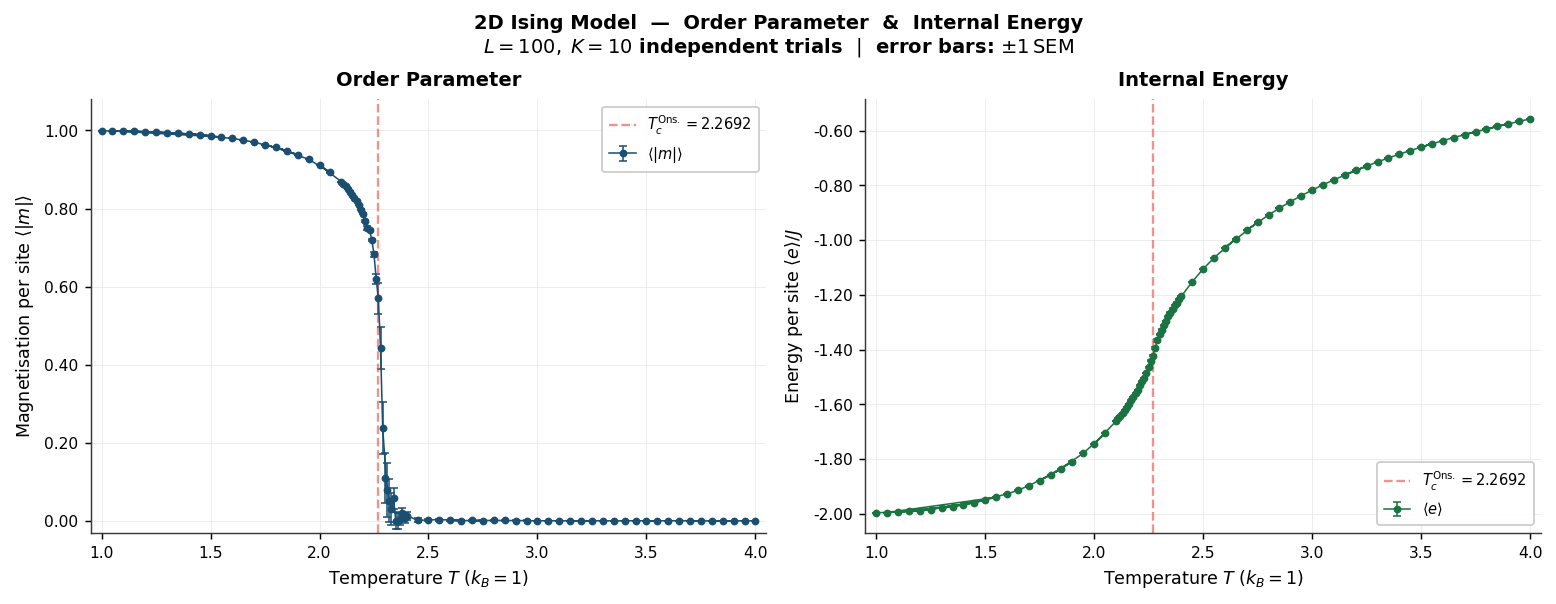

✓  fig_magnetisation_energy.png


In [8]:
# ── Cell 4 · Order Parameter & Internal Energy ────────────────────────────────
#
# Rendering strategy:
#   • plt.errorbar  — small circular markers connected by a thin line;
#     error bars show the inter-trial SEM, not a continuous shaded band.
#     This is the standard representation in Physical Review Letters / Nature Physics.
#   • T_c line is drawn with alpha=0.6, lw=1.2 — present but not dominating.
#   • Left panel  : ⟨|m|⟩ → second-order collapse; SEM widens at T_c where
#     critical fluctuations decorrelate individual trial outcomes.
#   • Right panel : ⟨e⟩   → continuous (no latent heat); confirms 2nd-order.

# ── Data extraction ───────────────────────────────────────────────────────────
T      = df["T"].values
m_abs  = df["m_abs_avg"].values
m_err  = df["m_err"].values
e_avg  = df["e_avg"].values
e_err  = df["e_err"].values

# ── Figure layout ─────────────────────────────────────────────────────────────
fig, axes = plt.subplots(
    1, 2, figsize=(11, 4.2),
    constrained_layout=True,
)
fig.suptitle(
    "2D Ising Model  —  Order Parameter  &  Internal Energy\n"
    r"$L = 100,\; K = 10$ independent trials  $|$  error bars: $\pm 1\,\mathrm{SEM}$",
    fontsize=10, fontweight="bold",
)

# helper: draw T_c annotation on any axis
def add_tc_line(ax, *, ymax_frac=0.92, label=True):
    lbl = (
        rf"$T_c^\mathrm{{Ons.}} = {T_C_EXACT:.4f}$"
        if label else None
    )
    ax.axvline(
        T_C_EXACT, color=PAL["tc"], linestyle="--",
        linewidth=1.2, alpha=0.6, label=lbl, zorder=2,
    )

# ── Left : Magnetisation ──────────────────────────────────────────────────────
ax = axes[0]
ax.errorbar(
    T, m_abs, yerr=m_err,
    color=PAL["m"], label=r"$\langle|m|\rangle$",
    **EB,
)
add_tc_line(ax)
ax.set_xlabel(r"Temperature $T \;(k_B = 1)$")
ax.set_ylabel(r"Magnetisation per site $\langle|m|\rangle$")
ax.set_title("Order Parameter")
ax.set_xlim(T.min() - 0.05, T.max() + 0.05)
ax.set_ylim(-0.03, 1.08)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
leg = ax.legend(loc="upper right", handlelength=1.8)

# ── Right : Internal Energy ───────────────────────────────────────────────────
ax = axes[1]
ax.errorbar(
    T, e_avg, yerr=e_err,
    color=PAL["e"], label=r"$\langle e \rangle$",
    **EB,
)
add_tc_line(ax)
ax.set_xlabel(r"Temperature $T \;(k_B = 1)$")
ax.set_ylabel(r"Energy per site $\langle e \rangle / J$")
ax.set_title("Internal Energy")
ax.set_xlim(T.min() - 0.05, T.max() + 0.05)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(loc="lower right", handlelength=1.8)

plt.savefig("fig_magnetisation_energy.png")
plt.show()
print("✓  fig_magnetisation_energy.png")


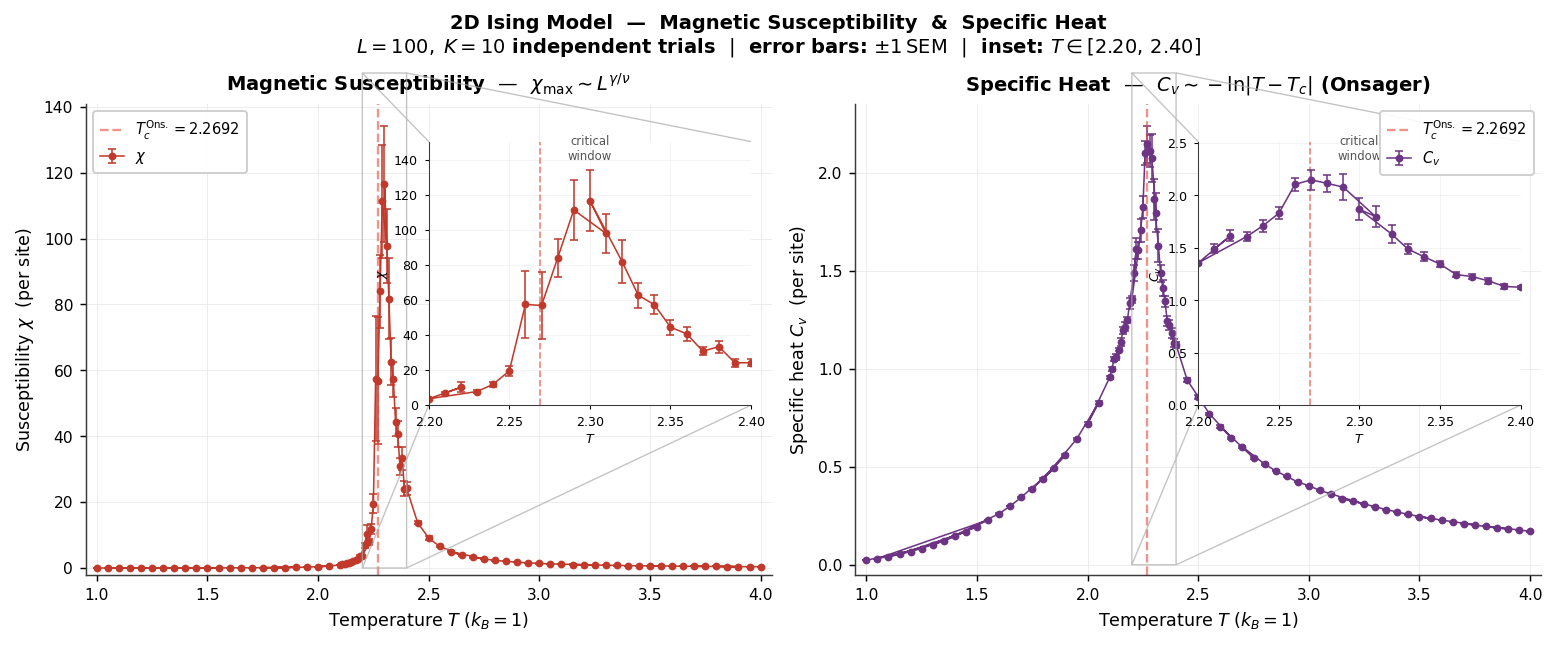

  T_c (Onsager exact)  = 2.269185
  χ  peak  at T = 2.300   (ΔT = +0.0308)
  Cv peak  at T = 2.270   (ΔT = +0.0008)
  χ_max  = 116.58  ±17.57
  Cv_max = 2.1470 ±0.0948
✓  fig_susceptibility_heat_capacity.png


In [9]:
# ── Cell 5 · Susceptibility & Specific Heat  +  Critical-Window Insets ────────
#
# Rendering strategy:
#   • Same errorbar aesthetic as Cell 4.
#   • ax.inset_axes  — a zoom window covering T ∈ [2.20, 2.40] is embedded
#     in the upper-right corner of each panel; this is where the divergence
#     is sharpest and the finite-size peak resolution is most meaningful.
#   • ax.indicate_inset_zoom draws the connector lines automatically.
#
# QUANT NOTE — finite-size shift:
#   For L=100 the expected peak displacement is |T_peak − T_c(∞)| ~ L^{-1/ν}
#   with ν=1 (2D Ising), giving ≈ 0.01–0.02.  The inset makes this sub-percent
#   shift legible without distorting the global view.

chi     = df["chi"].values
chi_err = df["chi_err"].values
cv      = df["cv"].values
cv_err  = df["cv_err"].values

# ── locate numerical peaks ────────────────────────────────────────────────────
chi_peak_idx = int(np.argmax(chi))
cv_peak_idx  = int(np.argmax(cv))

# ── zoom window for insets ────────────────────────────────────────────────────
ZOOM_LO, ZOOM_HI = 2.20, 2.40
zoom_mask = (T >= ZOOM_LO) & (T <= ZOOM_HI)

# ── Figure layout ─────────────────────────────────────────────────────────────
fig, axes = plt.subplots(
    1, 2, figsize=(11, 4.5),
    constrained_layout=True,
)
fig.suptitle(
    r"2D Ising Model  —  Magnetic Susceptibility  &  Specific Heat"
    "\n"
    r"$L = 100,\; K = 10$ independent trials  $|$  error bars: $\pm 1\,\mathrm{SEM}$  $|$  inset: $T \in [2.20,\,2.40]$",
    fontsize=10, fontweight="bold",
)

# ── helper: inset axes factory ────────────────────────────────────────────────
def make_inset(ax):
    """Create a zoom inset in the upper-right empty space of the panel."""
    axins = ax.inset_axes(
        [0.50, 0.36, 0.47, 0.56],   # [x0, y0, width, height] in axes fraction
        transform=ax.transAxes,
    )
    # Inset style: inherit spines but make them thinner
    for spine in axins.spines.values():
        spine.set_linewidth(0.55)
    axins.spines["top"].set_visible(False)
    axins.spines["right"].set_visible(False)
    axins.tick_params(
        labelsize=6.5, length=2, width=0.55, direction="out",
    )
    axins.set_xlim(ZOOM_LO, ZOOM_HI)
    axins.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
    axins.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    axins.grid(color="#EEEEEE", linewidth=0.35)
    axins.axvline(
        T_C_EXACT, color=PAL["tc"], linestyle="--",
        linewidth=0.9, alpha=0.65, zorder=2,
    )
    return axins


# ── Left : Susceptibility ─────────────────────────────────────────────────────
ax = axes[0]

ax.errorbar(
    T, chi, yerr=chi_err,
    color=PAL["chi"], label=r"$\chi$",
    **EB,
)
ax.axvline(
    T_C_EXACT, color=PAL["tc"], linestyle="--",
    linewidth=1.2, alpha=0.6,
    label=rf"$T_c^\mathrm{{Ons.}} = {T_C_EXACT:.4f}$",
    zorder=2,
)
ax.set_xlabel(r"Temperature $T \;(k_B = 1)$")
ax.set_ylabel(r"Susceptibility $\chi$  (per site)")
ax.set_title(r"Magnetic Susceptibility  —  $\chi_\mathrm{max} \sim L^{\gamma/\nu}$")
ax.set_xlim(T.min() - 0.05, T.max() + 0.05)
ax.set_ylim(bottom=-2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(loc="upper left", handlelength=1.6)

# ── inset: χ critical window ──────────────────────────────────────────────────
axins_chi = make_inset(ax)
axins_chi.errorbar(
    T[zoom_mask], chi[zoom_mask], yerr=chi_err[zoom_mask],
    color=PAL["chi"], **EB,
)
chi_zoom_max = (chi[zoom_mask] + chi_err[zoom_mask]).max()
axins_chi.set_ylim(bottom=0, top=chi_zoom_max * 1.12)
axins_chi.set_xlabel(r"$T$", fontsize=6.5, labelpad=2)
axins_chi.set_ylabel(r"$\chi$", fontsize=6.5, labelpad=2)
axins_chi.annotate(
    "critical\nwindow",
    xy=(0.50, 0.93), xycoords="axes fraction",
    fontsize=6, ha="center", color="#555555",
)

# connector lines — indicate_inset_zoom draws the shaded rectangle + lines
ax.indicate_inset_zoom(axins_chi, edgecolor="#AAAAAA", linewidth=0.7, alpha=0.7)

# ── Right : Specific Heat ─────────────────────────────────────────────────────
ax = axes[1]

ax.errorbar(
    T, cv, yerr=cv_err,
    color=PAL["cv"], label=r"$C_v$",
    **EB,
)
ax.axvline(
    T_C_EXACT, color=PAL["tc"], linestyle="--",
    linewidth=1.2, alpha=0.6,
    label=rf"$T_c^\mathrm{{Ons.}} = {T_C_EXACT:.4f}$",
    zorder=2,
)
ax.set_xlabel(r"Temperature $T \;(k_B = 1)$")
ax.set_ylabel(r"Specific heat $C_v$  (per site)")
ax.set_title(r"Specific Heat  —  $C_v \sim -\ln|T - T_c|$ (Onsager)")
ax.set_xlim(T.min() - 0.05, T.max() + 0.05)
ax.set_ylim(bottom=-0.05)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(loc="upper right", handlelength=1.6)

# ── inset: Cv critical window ─────────────────────────────────────────────────
axins_cv = make_inset(ax)
axins_cv.errorbar(
    T[zoom_mask], cv[zoom_mask], yerr=cv_err[zoom_mask],
    color=PAL["cv"], **EB,
)
cv_zoom_max = (cv[zoom_mask] + cv_err[zoom_mask]).max()
axins_cv.set_ylim(bottom=0, top=cv_zoom_max * 1.12)
axins_cv.set_xlabel(r"$T$", fontsize=6.5, labelpad=2)
axins_cv.set_ylabel(r"$C_v$", fontsize=6.5, labelpad=2)
axins_cv.annotate(
    "critical\nwindow",
    xy=(0.50, 0.93), xycoords="axes fraction",
    fontsize=6, ha="center", color="#555555",
)

ax.indicate_inset_zoom(axins_cv, edgecolor="#AAAAAA", linewidth=0.7, alpha=0.7)

# ── Save + summary ────────────────────────────────────────────────────────────
plt.savefig("fig_susceptibility_heat_capacity.png")
plt.show()

print("=" * 62)
print(f"  T_c (Onsager exact)  = {T_C_EXACT:.6f}")
print(f"  χ  peak  at T = {T[chi_peak_idx]:.3f}   "
      f"(ΔT = {T[chi_peak_idx] - T_C_EXACT:+.4f})")
print(f"  Cv peak  at T = {T[cv_peak_idx]:.3f}   "
      f"(ΔT = {T[cv_peak_idx] - T_C_EXACT:+.4f})")
print(f"  χ_max  = {chi[chi_peak_idx]:.2f}  ±{chi_err[chi_peak_idx]:.2f}")
print(f"  Cv_max = {cv[cv_peak_idx]:.4f} ±{cv_err[cv_peak_idx]:.4f}")
print("=" * 62)
print("✓  fig_susceptibility_heat_capacity.png")
